# Libraries to be imported

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt
from ecg_detectors.ecgdetectors import panPeakDetect, searchBack
import wfdb
import scipy.signal as signal
import peakutils
import os
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

# Loading the Data

In [54]:
flist = os.listdir('/Users/chaitanya/Downloads/ecg-id-database-1.0.0/Person_02/')
flist = [file for file in flist if file.endswith('.dat')]

In [55]:
records={}
signal_slice={}
filtered_signal={}
smoothed_signal={}
r_peaks={}
flist = os.listdir('/Users/chaitanya/Downloads/ecg-id-database-1.0.0/Person_02/')
flist = [file for file in flist if file.endswith(".dat")]   
for file in flist:
    records[file] = wfdb.rdrecord('/Users/chaitanya/Downloads/ecg-id-database-1.0.0/Person_02/'+file[:-4],channels=[1])

In [56]:
data={}
for rec in records:
    data[rec] = np.ndarray.flatten(records[rec].p_signal[:])

In [57]:
times={}
fs=200
for rec in records:
    times[rec] = np.arange(data[rec].shape[0], dtype='float') / fs

# Pre-processing the signal

In [58]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog=False, btype="band", output="sos")
    return sos

def butter_bandpass_forward_backward_filter(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfiltfilt(sos,
                    data)  # Apply a digital filter forward and backward to a signal.This function applies a linear digital filter twice, once forward and once backwards. The combined filter has zero phase and a filter order twice that of the original.
    return y

# CHOOSING PAN_TOMPKINS_DETECTOR, AS IT IS THE MOST EFFICIENT R-PEAK DETECTOR

In [59]:
def pan_tompkins_detector(raw_ecg, mwa, fs, N):
#     N = int(0.12 * fs)
#     mwa = MWA(squared, N)
#     mwa[:int(0.2 * fs)] = 0

    N = int(N / 100 * fs)
    mwa_peaks = panPeakDetect(mwa, fs)

    r_peaks = searchBack(mwa_peaks, raw_ecg, N)

    return r_peaks

In [60]:
lowcut = 0.05 * 3.3  
highcut = 15 
x={}
times={}
y={}
for rec in records:
    x[rec] = data[rec][:]
    times[rec] = np.arange(x[rec].shape[0], dtype='float') / fs
    y[rec] = butter_bandpass_forward_backward_filter(x[rec], lowcut, highcut, fs, order=4)

In [61]:
for rec in records:
    smoothed_signal[rec]=signal.cspline1d(y[rec],lamb=500)

# Finding : r-peaks

In [62]:
differentiated_ecg_measurements={}
squared_ecg_measurements={}
integration_window = 50
integrated_ecg_measurements={}
rpeaks={}
for rec in records:
    differentiated_ecg_measurements[rec] = np.ediff1d(y[rec])

    # Squaring - intensifies values received in derivative. 
    # This helps restrict false positives caused by T waves with higher than usual spectral energies..
    squared_ecg_measurements[rec] = differentiated_ecg_measurements[rec] ** 2

    # Moving-window integration.
    # Change proportionally when adjusting frequency (in samples)
    integrated_ecg_measurements[rec] = np.convolve(squared_ecg_measurements[rec], np.ones(integration_window))

    # Fiducial mark - peak detection on integrated measurements.
    rpeaks[rec] = pan_tompkins_detector(smoothed_signal[rec], integrated_ecg_measurements[rec], fs, integration_window)

# Plot to check the r_peaks

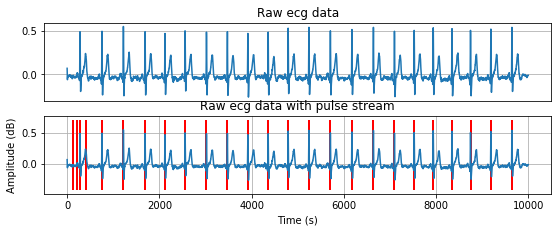

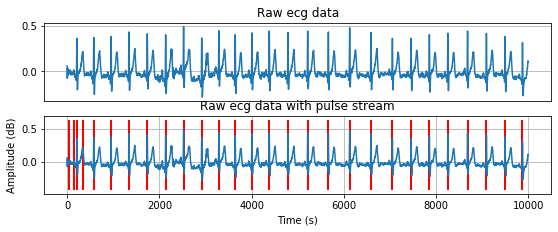

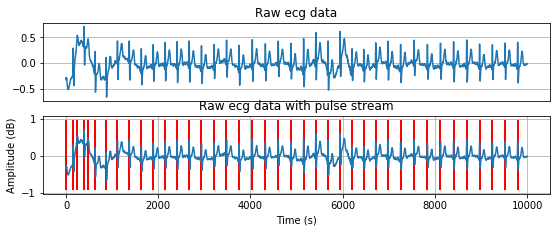

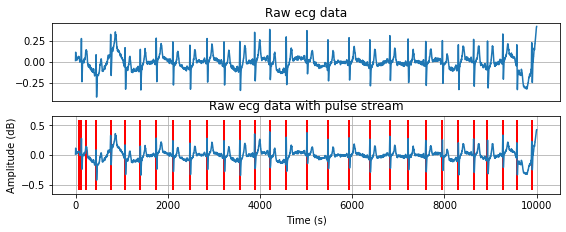

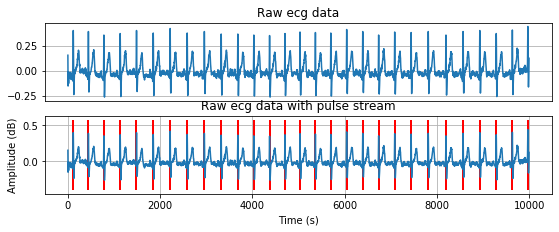

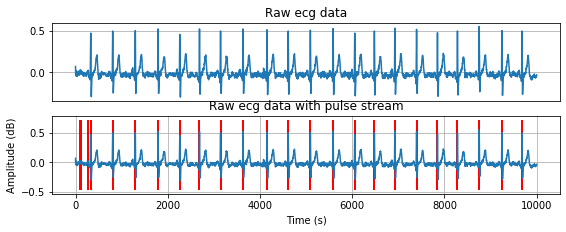

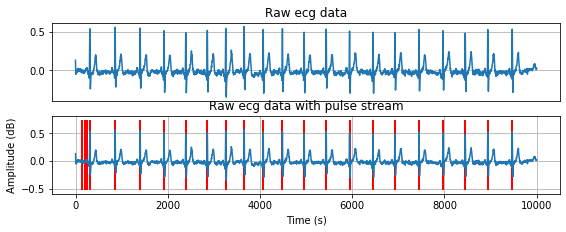

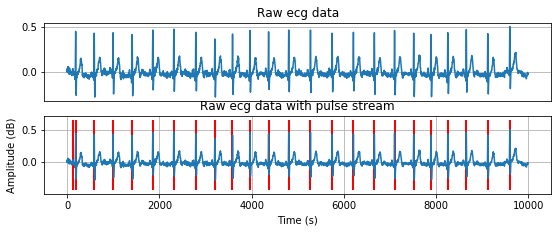

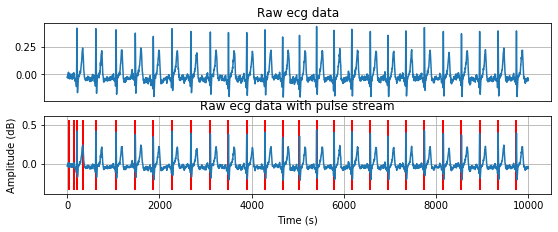

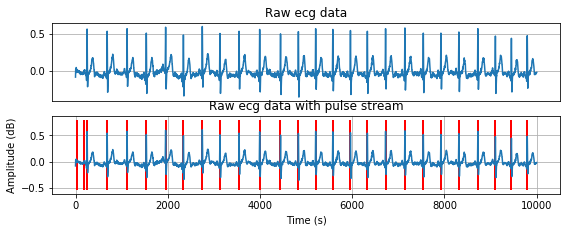

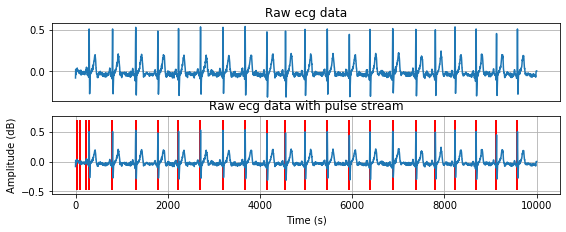

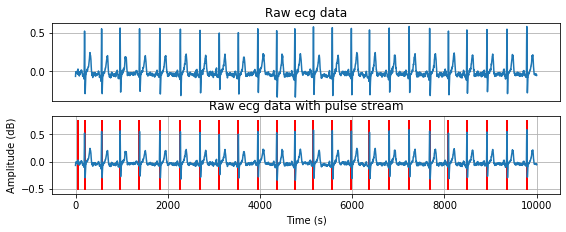

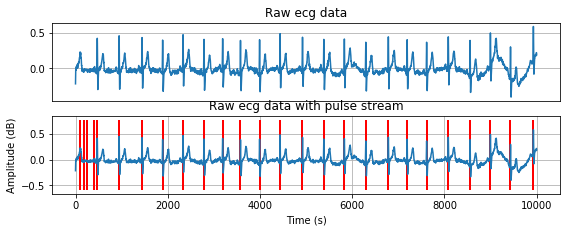

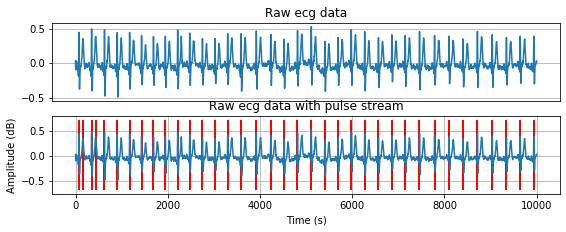

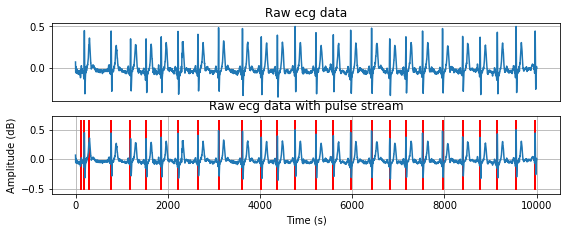

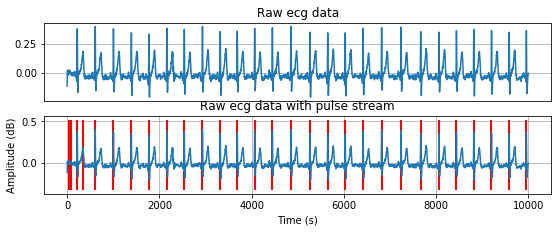

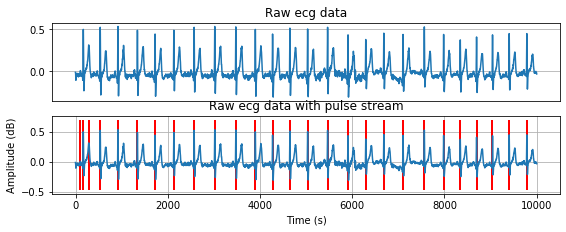

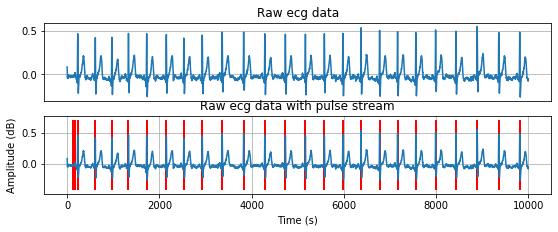

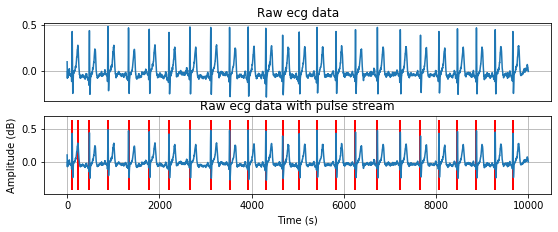

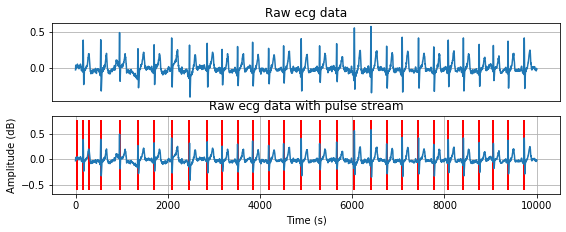

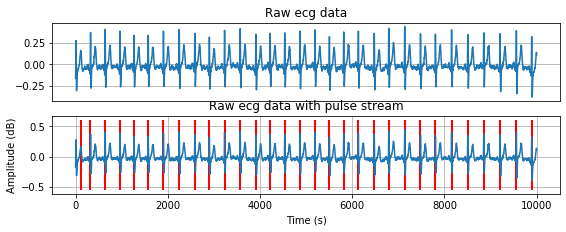

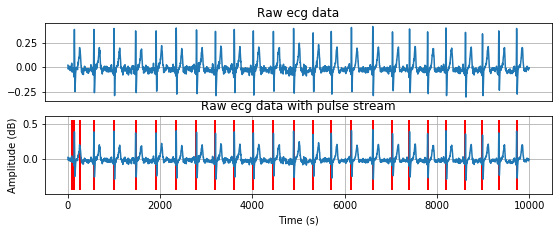

In [63]:
figsize = (20, 10)

ymin={}
ymax={}

for rec in records:
    plt.figure(figsize=figsize)

    plt.subplot2grid((6, 2), (0, 0))
    # plt.subplot(621)
    # plt.figure(1, figsize=left_figsize)
    # plt.clf()
    plt.xticks([])
    plt.plot(data[rec])
    plt.title("Raw ecg data")
    plt.grid(True)
    
    ymin[rec] = np.min(data[rec])
    ymax[rec] = np.max(data[rec])
    alpha = 0.2 * (ymax[rec] - ymin[rec])
    ymax[rec] += alpha
    ymin[rec] -= alpha

    # plt.figure(figsize=left_figsize)
    # plt.subplot(626)
    plt.subplot2grid((6, 2), (1, 0))
    # plt.clf()
    plt.ylabel("Amplitude (dB)")
    # Calculate time values in seconds
    times = np.arange(data[rec].shape[0], dtype='float')
    plt.xlabel("Time (s)")
    plt.plot(times, data[rec])
    plt.vlines(rpeaks[rec], ymin[rec], ymax[rec],
               color="r",
               linewidth=2,
               label="R-peaks")
    plt.title("Raw ecg data with pulse stream")
    plt.grid(True)

# Crop the signal from rpeaks

# Determine the min_length of a signal

Since the r-peak detected at the initial time of a signal is improper. I've consider the minimum distance between the r-peaks be the average of smallest distance and largest distance.

In [64]:
min_dist={}
min_dist_mn={}
for rec in records:
    min_dist_mn[rec]=[]
    for peak in range(len(rpeaks[rec])-1):
        min_dist_mn[rec].append(rpeaks[rec][peak+1]-rpeaks[rec][peak])
    dist_min = min(min_dist_mn[rec])
    dist_max = max(min_dist_mn[rec])
    dist_avg = (dist_min+dist_max)//2
    min_dist[rec]=dist_avg         

# Slicing the signal

In [65]:
series_slice={}

for rec in records:
    count=0
    series_slice[rec]={}
    for peak in range(len(rpeaks[rec])-1):
        if len(data[rec][rpeaks[rec][peak]:rpeaks[rec][peak+1]])>min_dist[rec]:
            series_slice[rec][count]=data[rec][rpeaks[rec][peak]:rpeaks[rec][peak+1]]
            count=count+1

# Plotting the sliced signals

In [66]:
import plotly.graph_objects as go
fig=go.Figure()
for rec in records:
    for peak in range(len(series_slice[rec])-1):
        fig.add_trace(go.Scatter(
            y=series_slice[rec][peak],
            mode="lines",
            name=rec
    ))
# Titles=""
# for i in range(num_discords):
#     Title=discords['sel803.dat'][i][0]
#     Titles+=" "+str(Title)
fig.update_layout(
title="Signal_slice",
xaxis_title="X",
yaxis_title="F",
autosize=True,
margin=dict(
    l=50,
    r=50,
    b=100,
    t=100,
    pad=20
),
# paper_bgcolor="LightSteelBlue",
font=dict(
    family="Courier New, monospace",
    size=18,
    color="Blue"
    )
)
fig.show()

In [121]:
fig=go.Figure()
fig1=go.Figure()

for rec in range(len(series_slice['rec_2.dat'])):
    fig.add_trace(go.Scatter(
        y=series_slice['rec_2.dat'][rec],
        mode="lines+markers",
    ))

fig.update_layout(
    title="Signal_slice : rec_2.dat",
    xaxis_title="Time",
    yaxis_title="Values",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="Blue"
    )
)

fig.show()

# RMSE

In [68]:
def rms_dd(s_array):
    rmse_={}
    for i in range(len(s_array)):
        data1f=np.array(s_array[i][:50])
        data1l=np.array(s_array[i][-50:])
        data1=np.concatenate((data1f,data1l),axis=0)
        rmse_[i]={}
        
        for j in range(len(s_array)):
            sum1=0
            data2f=np.array(s_array[j][:50])
            data2l=np.array(s_array[j][-50:])
            data2=np.concatenate((data2f,data2l),axis=0)
#             if len(s_array[i])>len(s_array[j]):
#                 data1=s_array[i][0:(len(s_array[i])-(len(s_array[i])-len(s_array[j])))]
#             elif len(s_array[j]>len(s_array[i])):
#                 data2=s_array[j][0:(len(s_array[j])-(len(s_array[j])-len(s_array[i])))]
            for k in range(len(data1)):
                m=len(data1)
                sum1=sum1+((abs(data1[k]-data2[k]))**2)
            rmse_[i][j]=(np.sqrt(sum1))/m
    return rmse_

# MSE

In [105]:
def mse_dd(s_array):
    mse_={}

    for i in range(len(s_array)):
        data1=np.array(s_array[i])
        mse_[i]={}
        
        for j in range(len(s_array)):
            sum1=0
            data2=np.array(s_array[j])
            if len(s_array[i])>len(s_array[j]):
                data1=s_array[i][0:(len(s_array[i])-(len(s_array[i])-len(s_array[j])))]
            elif len(s_array[j]>len(s_array[i])):
                data2=s_array[j][0:(len(s_array[j])-(len(s_array[j])-len(s_array[i])))]
                
            #Normalize the data b/w 0 and 1
            
            norm1=((data1-min(data1))/(max(data1)-min(data1)))
            norm2=((data2-min(data2))/(max(data2)-min(data2)))

            for k in range(len(norm1)):
                m=len(norm1)
                sum1=sum1+((abs(norm1[k]-norm2[k]))**2)
            mse_[i][j]=(sum1)/m
    return mse_

In [85]:
rmse={}
for rec in records:
    rmse[rec]=rms_dd(series_slice[rec])

In [106]:
mse={}
for rec in records:
    mse[rec]=mse_dd(series_slice[rec])

In [107]:
mse

{'rec_8.dat': {0: {0: 0.0,
   1: 0.06080777097795957,
   2: 0.05538063806524519,
   3: 0.06478572821961326,
   4: 0.060706521033439126,
   5: 0.048519006438203616,
   6: 0.06214720443987083,
   7: 0.06142895637581122,
   8: 0.07931403392715047,
   9: 0.057033784618963815,
   10: 0.05111980523884326,
   11: 0.05399974630934841,
   12: 0.06136604203663358,
   13: 0.05822101654670979,
   14: 0.04967720784890611,
   15: 0.06626489465103931,
   16: 0.057653692367893666,
   17: 0.04608569744617652,
   18: 0.06564222583151828,
   19: 0.05793901427839113,
   20: 0.04840326910237887},
  1: {0: 0.06080777097795957,
   1: 0.0,
   2: 0.0006698597618194279,
   3: 0.0038531473001295665,
   4: 0.00492878125006381,
   5: 0.0023733853296234865,
   6: 0.00415599265963336,
   7: 0.0038007020907189796,
   8: 0.005633518995547517,
   9: 0.005103658320492178,
   10: 0.004485410970487593,
   11: 0.0007836998780939428,
   12: 0.0005962747834332275,
   13: 0.0004948756415163116,
   14: 0.005103509989487672,
  

# For each record, for each signal slice, the signal with maximum RMSE is picked :

In [92]:
def abnormal_discord_rmse():
    v={}
    for rec in records:
        v[rec]={}
        for val in range(len(rmse[rec])):
            val1=[(x,y) for x,y in rmse[rec][val].items() if y==max(rmse[rec][val].values())]
            v[rec][val]=val1
            v[rec][val]=np.array(v[rec][val]).flatten()
    return v

In [93]:
def abnormal_discord_mse():
    v={}
    for rec in records:
        v[rec]={}
        for val in range(len(mse[rec])):
            val1=[(x,y) for x,y in mse[rec][val].items() if y==max(mse[rec][val].values())]
            v[rec][val]=val1
            v[rec][val]=np.array(v[rec][val]).flatten()
    return v

In [97]:
ab_discords_rmse=abnormal_discord_rmse()

In [94]:
ab_discords_mse=abnormal_discord_mse()

In [99]:
ab_discords_mse['rec_8.dat'][0][0]

8.0

In [117]:
ab_discords_rmse['rec_2.dat']

{0: array([1.        , 0.01436576]),
 1: array([0.        , 0.01436576]),
 2: array([1.        , 0.00948723]),
 3: array([1.        , 0.00859811]),
 4: array([0.        , 0.01182772]),
 5: array([1.        , 0.01303888]),
 6: array([1.50000000e+01, 9.11797675e-03]),
 7: array([1.        , 0.00917442]),
 8: array([1.        , 0.00911853]),
 9: array([0.        , 0.00859113]),
 10: array([1.        , 0.00882964]),
 11: array([0.       , 0.0089836]),
 12: array([1.        , 0.00938829]),
 13: array([1.        , 0.00882992]),
 14: array([5.        , 0.01097144]),
 15: array([1.        , 0.01049548]),
 16: array([0.     , 0.00915]),
 17: array([1.        , 0.00925351]),
 18: array([1.        , 0.00856898]),
 19: array([0.        , 0.00932671]),
 20: array([1.        , 0.01003419]),
 21: array([1.        , 0.00826952]),
 22: array([0.        , 0.00923093]),
 23: array([1.        , 0.01060778]),
 24: array([0.       , 0.0083512]),
 25: array([0.        , 0.00832646])}

In [116]:
ab_discords_mse['rec_2.dat']

{0: array([1.        , 0.06227525]),
 1: array([5.        , 0.11287634]),
 2: array([1.        , 0.08532012]),
 3: array([5.        , 0.03534452]),
 4: array([5.      , 0.040133]),
 5: array([1.        , 0.11287634]),
 6: array([1.        , 0.03955296]),
 7: array([1.        , 0.03950322]),
 8: array([1.        , 0.05038836]),
 9: array([5.        , 0.03248318]),
 10: array([1.        , 0.04367382]),
 11: array([1.        , 0.03371221]),
 12: array([1.        , 0.04172742]),
 13: array([1.        , 0.03805546]),
 14: array([5.        , 0.08679921]),
 15: array([5.        , 0.05355296]),
 16: array([5.        , 0.03388468]),
 17: array([1.        , 0.03256028]),
 18: array([1.        , 0.03875826]),
 19: array([5.        , 0.02880786]),
 20: array([1.        , 0.06844198]),
 21: array([1.       , 0.0303908]),
 22: array([1.       , 0.0285509]),
 23: array([1.        , 0.04558632]),
 24: array([5.        , 0.06162127]),
 25: array([1.        , 0.03586483])}

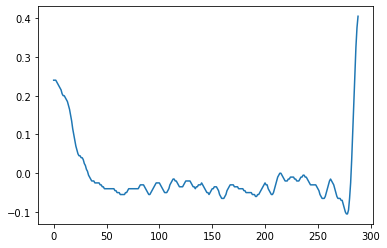

In [113]:
plt.plot(series_slice['rec_10.dat'][0])

In [110]:
len(series_slice['rec_9.dat'])

23

In [31]:
len(ab_discords['rec_8.dat'])

21

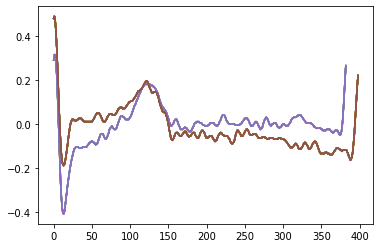

In [120]:
for sig in range(len(series_slice['rec_2.dat'])):
    plt.plot(series_slice['rec_2.dat'][ab_discords_mse['rec_2.dat'][sig][0]])

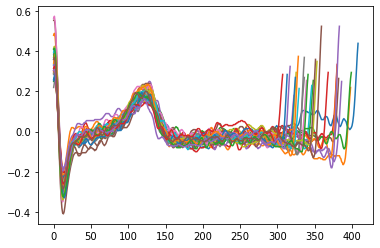

In [115]:
for sig in range(len(series_slice['rec_2.dat'])):
    plt.plot(series_slice['rec_2.dat'][sig])

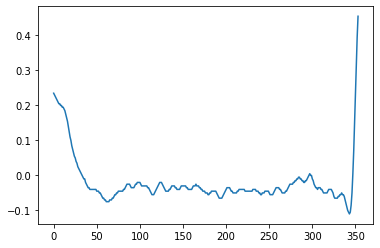

In [52]:
plt.plot(series_slice['rec_8.dat'][ab_discords['rec_8.dat'][2][0]])

In [48]:
ab_discords

{'rec_8.dat': {0: array([8.        , 0.01474576]),
  1: array([0.        , 0.01414532]),
  2: array([0.        , 0.01450819]),
  3: array([0.        , 0.01414638]),
  4: array([0.        , 0.01419639]),
  5: array([0.        , 0.01267488]),
  6: array([0.        , 0.01327422]),
  7: array([0.        , 0.01420123]),
  8: array([0.        , 0.01474576]),
  9: array([0.        , 0.01443182]),
  10: array([0.        , 0.01382145]),
  11: array([0.        , 0.01420299]),
  12: array([0.        , 0.01426955]),
  13: array([0.        , 0.01388308]),
  14: array([0.        , 0.01389118]),
  15: array([0.        , 0.01459452]),
  16: array([0.        , 0.01370803]),
  17: array([0.        , 0.01413515]),
  18: array([0.        , 0.01473855]),
  19: array([0.        , 0.01451887]),
  20: array([0.       , 0.0136347])},
 'rec_9.dat': {0: array([5.        , 0.00656658]),
  1: array([5.        , 0.00758337]),
  2: array([5.        , 0.00620504]),
  3: array([6.        , 0.00715943]),
  4: array([5.